<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import pydot
from IPython.core.display import Image, display  

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

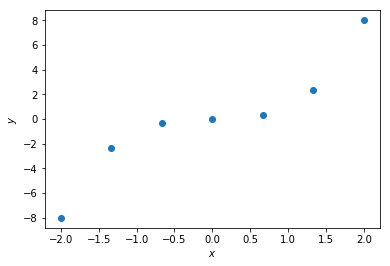

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

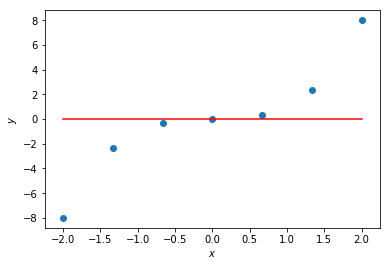

In [3]:
# Ваш код здесь

plt.plot(np.linspace(-2,2,200), np.array([np.mean(y) for __ in range(200)]), 'r') 
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

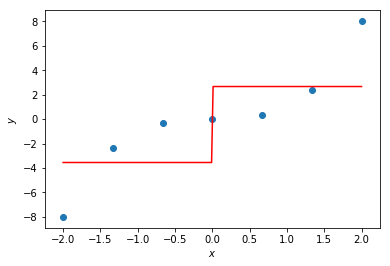

In [4]:
# Ваш код здесь
pairs=np.array(list(zip(X,y)))

plt.plot(np.linspace(-2,2,200), [np.mean([el[1] for el in pairs if el[0] <0]) for __ in range(100)]+
         [np.mean([el[1] for el in pairs if el[0] >=0]) for __ in range(100)], 'r') 
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    DX=np.std(y)
    n=len(X)
    t=len(X[X<t])
    DX_t=np.std(y[:t])
    DX_r=np.std(y[t:])
    return DX -DX_t*t /n-DX_r*(n-t) /n

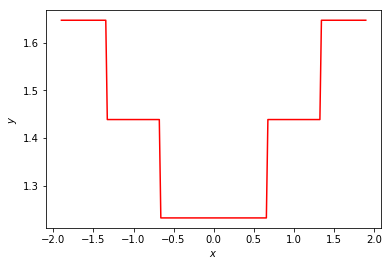

In [6]:
# Ваш код здесь
xs=np.linspace(-1.9,1.9,200)
plt.plot(xs,[regression_var_criterion(X, y, x) for x in xs],  'r') 
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- **Да**
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [7]:
# Ваш код здесь
nodes=[-1.5,0,1.5]

[len(X[X<leaf]) for leaf in nodes]

[1, 3, 6]

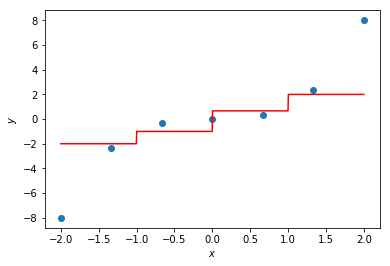

In [8]:
plt.scatter(X, y)
plt.plot(np.linspace(-2,2,800),[np.mean(X[:1]) for x in range(200)]+
         [np.mean(X[1:3]) for x in range(200)]+
         [np.mean(X[3:6]) for x in range(200)]+[np.mean(X[6:]) for x in range(200)],'r')

plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- **7**
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [9]:
#df = pd.read_csv('../../data/mlbootcamp5_train.csv', index_col='id', sep=';')
df = pd.read_csv('data/mlbootcamp5_train.csv', sep=';', index_col='id')

In [10]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [11]:
# Ваш код здесь
df['age_years']=df['age'].apply(lambda x:np.round(x/365.25,0))
df_dummi=pd.get_dummies(df,columns=['cholesterol','gluc'],prefix=['cholesterol','gluc'])

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df_dummi.drop('cardio',axis=1),df.cardio,test_size=0.3) # Ваш код здесь

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [13]:
# Ваш код здесь
clf_tree=DecisionTreeClassifier(random_state=17,max_depth=3)
clf_tree.fit(X_train,y_train)
#, export_graphviz
#export_graphviz(clf_tree,feature_names=X_train.columns,out_file='small_tree.dot',filled=True)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

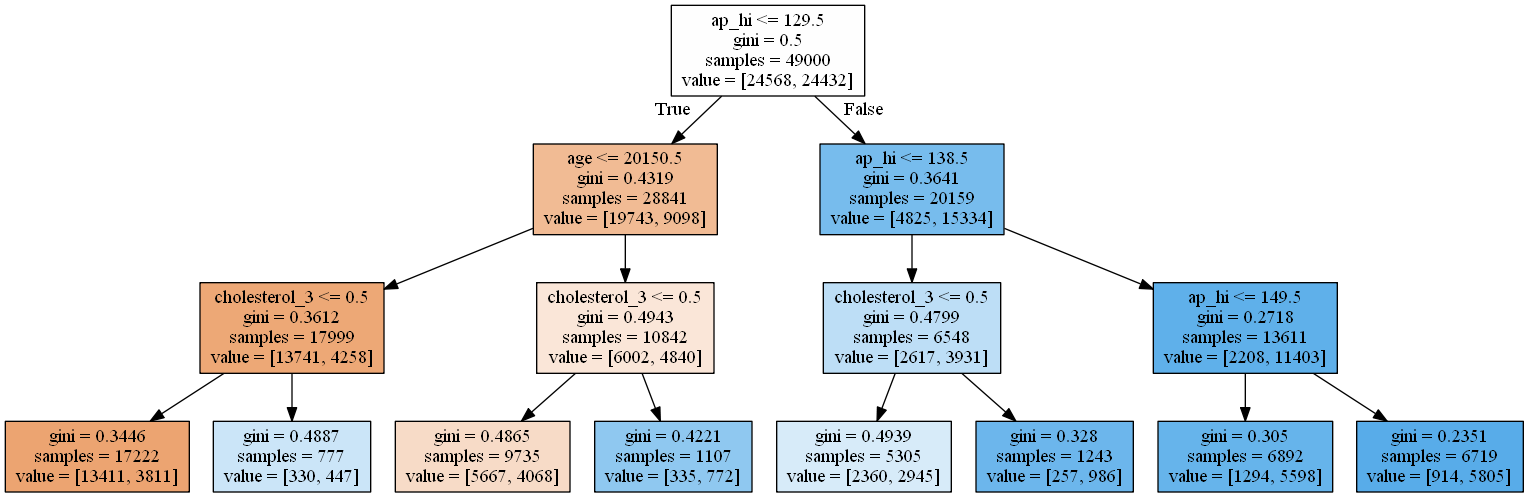

In [14]:
def draw_tree(clf,feature_names):
    dot_data=export_graphviz(clf,feature_names=feature_names,out_file=None,filled=True)
    (graph,) = pydot.graph_from_dot_data(dot_data) 
    return Image(graph.create_png())
draw_tree(clf_tree,X_train.columns)

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [15]:
# Ваш код здесь
y_test=clf_tree.predict(X_valid)
acc_score=accuracy_score(y_valid,y_test)
acc_score

0.72257142857142853

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [16]:
# Ваш код здесь
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), 
                         tree_params, 
                         scoring='accuracy',cv=5) 
tree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [17]:
# Ваш код здесь
tree_grid_df=pd.DataFrame(tree_grid.cv_results_)[[  'params','mean_test_score','std_test_score']]
tree_grid_df['max_depth']=tree_grid_df.params.apply(lambda x:x['max_depth'])
tree_grid_df.drop('params',axis=1,inplace=True)
tree_grid_df

,mean_test_score,std_test_score,max_depth
0,0.715857,0.004386,2
1,0.727163,0.004447,3
2,0.730857,0.004188,4
3,0.732980,0.003183,5
4,0.730980,0.002702,6
5,0.730347,0.003032,7
6,0.729673,0.003395,8
7,0.729714,0.004681,9
8,0.727469,0.004592,10


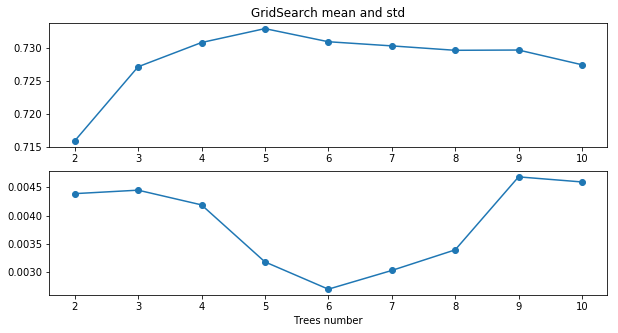

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('GridSearch mean and std')
plt.plot(tree_grid_df.max_depth,tree_grid_df.mean_test_score,'-o')
plt.subplot(2,1,2)
plt.plot(tree_grid_df.max_depth,tree_grid_df.std_test_score,'-o')
plt.xlabel('Trees number');

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [19]:
y_test=clf_tree.predict(X_valid)
acc_score=accuracy_score(y_valid,y_test)
acc_score

0.72257142857142853

In [20]:
# Ваш код здесь
acc_score_new=accuracy_score(y_valid,tree_grid.best_estimator_ .predict(X_valid))
acc_score_new

0.72842857142857143

In [21]:
acc_score

0.72257142857142853

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- **да, нет**
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [22]:
def  segm_age(age):
    if age >=65 or age<45:
        res='skip'
    elif age>= 60 :
        res='60+'
    elif age>=55:
        res='55-60'
    elif age >=50:
        res='50-55'
    else :res='45-50'
    return res

def ap_hi_segm(ap_hi):
    if ap_hi >=180 or ap_hi<120:
        res='skip'
    elif ap_hi>= 160 :
        res='160+'
    elif ap_hi>=140:
        res='140-160'
    else :res='120-140' 
    return res
    

df['age_segm']=df.age_years.apply(lambda x:segm_age(x))
df['ap_hi_segm']=df.ap_hi.apply(lambda x:ap_hi_segm(x))
df=df[(df['ap_hi_segm']!='skip')&(df['age_segm']!='skip')].reset_index(drop=True)
df['male']=df['gender'].apply(lambda x:0 if x==1 else 1)

In [23]:
dummi_columns=['male','age_segm','ap_hi_segm','cholesterol']
df_dummi=pd.get_dummies(df[dummi_columns],columns=dummi_columns,prefix=dummi_columns)

In [24]:
clf=DecisionTreeClassifier(random_state=17, max_depth=3)
clf.fit(df_dummi,df.cardio)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

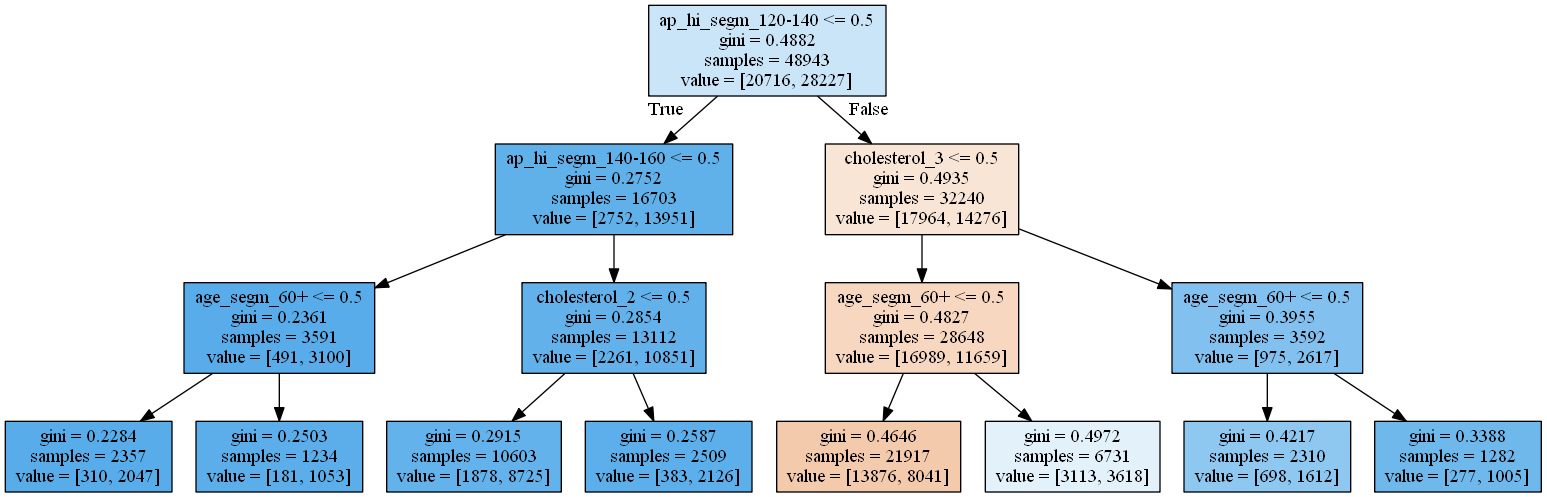

In [25]:
draw_tree(clf,df_dummi.columns)